In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading ---
df = pd.read_csv("dataset.csv", delimiter=";")



In [2]:
# --- Helper Function for Date Cleaning ---
def fix_date(col):
    """Converts YYYYMMDD(.0) float/int columns to datetime objects."""
    return (
        col.astype(str)
        .str.replace(".0", "", regex=False)
        .str.zfill(8)
        .pipe(pd.to_datetime, format="%Y%m%d", errors="coerce")
    )

# --- Data Cleaning/Type Conversion ---

# Columns that need fixing from YYYYMMDD(.0) format
raw_yyyymmdd_cols = [
    "document_create_date",
    "document_create_date.1",
    "due_in_date",
    "baseline_create_date"
]

for col in raw_yyyymmdd_cols:
    df[col] = fix_date(df[col])

# Columns that are already date strings
proper_date_cols = [
    "posting_date",
    "clear_date"
]

for col in proper_date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")


In [3]:

# --- Customer ID Cleaning/Mapping (for stable aggregation) ---

# 1. Create artificial ID for each unique cust_number
unique_customers_number = df["cust_number"].unique()
unique_customers = sorted(unique_customers_number)
mapping = {
    cust: 100000 + i
    for i, cust in enumerate(unique_customers)
}
df["customer_alt_id"] = df["cust_number"].map(mapping)

# 2. Normalize customer name
df["name_normalized"] = (
    df["name_customer"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# 3. Find the most frequent name per customer_alt_id
name_counts = (
    df.groupby(["customer_alt_id", "name_normalized"])
    .size()
    .reset_index(name="count")
)

most_frequent_names = (
    name_counts
    .sort_values(["customer_alt_id", "count"], ascending=[True, False])
    .drop_duplicates(subset=["customer_alt_id"])
    .rename(columns={"name_normalized": "customer_clean_name"})
    .loc[:, ["customer_alt_id", "customer_clean_name"]]
)

df = df.merge(most_frequent_names, on="customer_alt_id", how="left")

# 4. Create unique display name (clean name + ID if name is shared)
name_counts_per_clean = most_frequent_names["customer_clean_name"].value_counts()
shared_names = name_counts_per_clean[name_counts_per_clean > 1].index

def make_display_name(row):
    base = row["customer_clean_name"]
    if base in shared_names:
        return f"{base} {row['customer_alt_id']}"
    else:
        return base

most_frequent_names["customer_display_name"] = most_frequent_names.apply(
    make_display_name, axis=1
)

df = df.merge(
    most_frequent_names[["customer_alt_id", "customer_display_name"]],
    on="customer_alt_id",
    how="left"
)

--- Summary: Internal Posting Delay ---
Total invoices: 50000
Invoices with effective posting delay (>1 day after creation): 10735 of 50000
Total cost of internal posting delays (opportunity cost): $128,481.42
Median cost per delayed invoice: $7.02

Percentiles (cost per delayed invoice):
P50: $7.02
P75: $15.45
P90: $27.72
P95: $39.06

--- Top 10 Customers by Total Internal Posting Delay Cost ---


,customer_alt_id,customer_display_name,total_delay_cost,n_delayed,total_days,avg_delay_days
0,100908,walmar trust,20655.972290,2571,3324,1.262918
1,100885,sa associates,5916.910156,487,693,1.383234
2,100986,cost corporation,4631.708715,447,703,1.505353
3,101095,kraft in,4018.962819,224,441,1.909091
4,100764,publi llc,3262.825526,109,177,1.566372
5,100891,cs wh systems,3233.906526,270,358,1.283154
6,100994,mcl corporation,3178.373816,154,522,3.262500
7,101098,kraft f corp,2642.429260,377,831,2.175393
8,100633,am co,2093.047482,338,1008,2.913295
9,100761,king s associates,2041.638912,113,163,1.393162


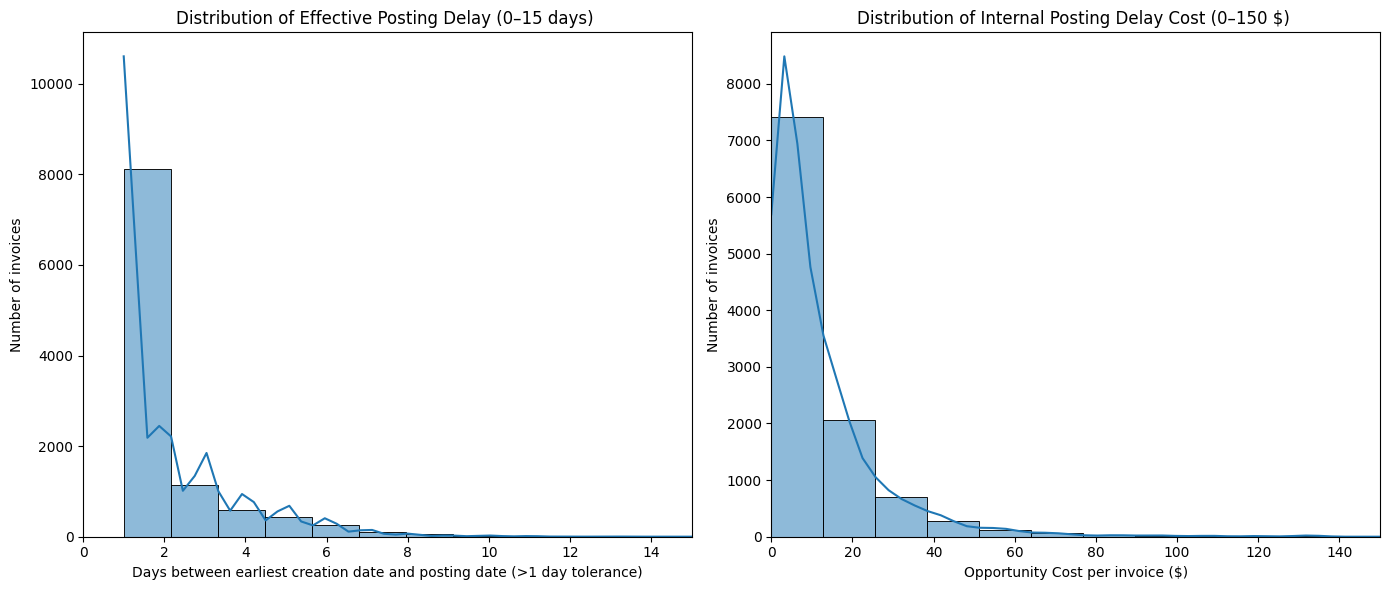

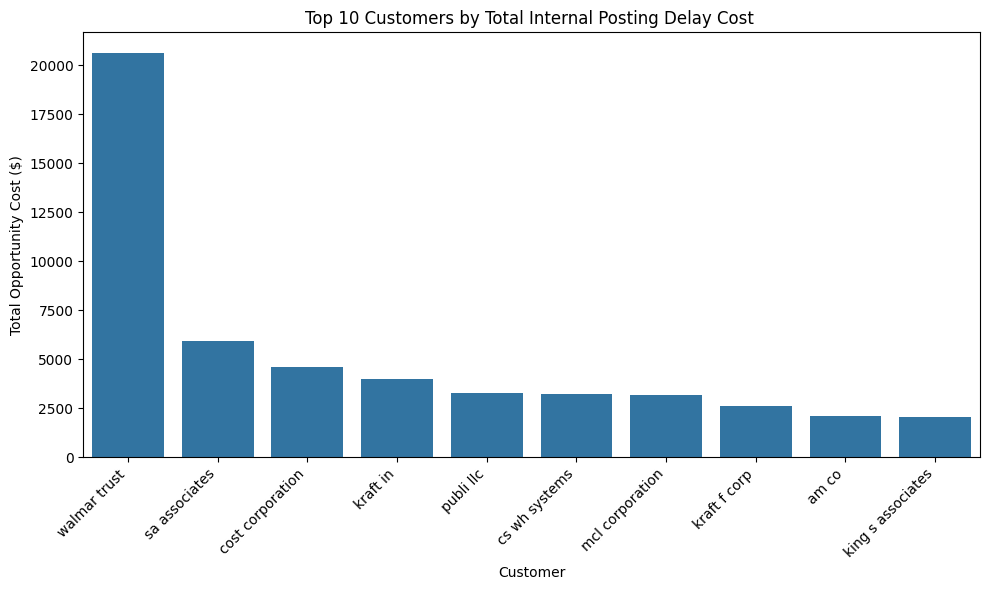

In [4]:

# ----------------------------------------------------
# INTERNAL DELAY ANALYSIS: Document Creation vs Posting Date
# ----------------------------------------------------

# 1. Find the earliest document creation date.
# There are two creation date fields; we take the minimum of the two,
# as this represents the first instance the invoice was generated internally.
df["earliest_creation_date"] = df[
    ["document_create_date", "document_create_date.1"]
].min(axis=1)

# 2. Calculate the delay in days. A positive delay means posting was LATER than creation.
# This delay shortens the payment window advertised in the payment terms.
df["posting_delay_days"] = (
    df["posting_date"] - df["earliest_creation_date"]
).dt.days

# 3. Apply a 1-day tolerance (posting on the same day or day after is acceptable)
# This calculation assumes that the delay cost only starts after the first acceptable day.
df["effective_posting_delay"] = df["posting_delay_days"].apply(
    lambda x: x - 1 if x > 1 else 0
)

# 4. Calculate the opportunity cost (cost of extending credit)
annual_rate = 0.10   # 10% annual cost of capital
daily_rate = annual_rate / 365

df["posting_delay_cost"] = (
    df["total_open_amount"] *
    daily_rate *
    df["effective_posting_delay"]
)

posting_delay_mask = df["effective_posting_delay"] > 0
total_delayed_invoices = posting_delay_mask.sum()
total_posting_delay_cost = df.loc[posting_delay_mask, "posting_delay_cost"].sum()
median_posting_delay_cost = df.loc[posting_delay_mask, "posting_delay_cost"].median()

print("--- Summary: Internal Posting Delay ---")
print(f"Total invoices: {len(df)}")
print(f"Invoices with effective posting delay (>1 day after creation): {total_delayed_invoices} of {len(df)}")
print(f"Total cost of internal posting delays (opportunity cost): ${total_posting_delay_cost:,.2f}")
print(f"Median cost per delayed invoice: ${median_posting_delay_cost:,.2f}")

percentiles = df.loc[posting_delay_mask, "posting_delay_cost"].quantile([0.50, 0.75, 0.90, 0.95])
print("\nPercentiles (cost per delayed invoice):")
for pct, value in percentiles.items():
    print(f"P{int(pct*100):>2}: ${value:,.2f}")

# ----------------------------------------------------
# Customer Level Analysis (Top 10 by Cost)
# ----------------------------------------------------

customer_posting_delay = (
    df.loc[posting_delay_mask]
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        total_delay_cost=("posting_delay_cost", "sum"),
        n_delayed=("invoice_id", "nunique"),
        total_days=("effective_posting_delay", "sum"),
        avg_delay_days=("effective_posting_delay", "mean")
    )
    .sort_values("total_delay_cost", ascending=False)
    .reset_index()
)

print("\n--- Top 10 Customers by Total Internal Posting Delay Cost ---")
display(customer_posting_delay.head(10))

# ----------------------------------------------------
# Visualization of Internal Posting Delay
# ----------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- Left: Delay in Days (Zoomed) ---
sns.histplot(
    df.loc[posting_delay_mask, "effective_posting_delay"],
    bins=50, kde=True,
    ax=axes[0]
)
axes[0].set_xlim(0, 15)
axes[0].set_title("Distribution of Effective Posting Delay (0–15 days) ")
axes[0].set_xlabel("Days between earliest creation date and posting date (>1 day tolerance)")
axes[0].set_ylabel("Number of invoices")

# --- Right: Delay Cost (Zoomed) ---
sns.histplot(
    df.loc[posting_delay_mask, "posting_delay_cost"],
    bins=50, kde=True,
    ax=axes[1]
)
axes[1].set_xlim(0, 150)
axes[1].set_title("Distribution of Internal Posting Delay Cost (0–150 $) ")
axes[1].set_xlabel("Opportunity Cost per invoice ($)")
axes[1].set_ylabel("Number of invoices")
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Visualization: Top 10 Customers by Total Cost
# ----------------------------------------------------

plt.figure(figsize=(10,6))

top10_posting_delay = customer_posting_delay.head(10)

sns.barplot(
    data=top10_posting_delay,
    x="customer_display_name",
    y="total_delay_cost"
)

plt.title("Top 10 Customers by Total Internal Posting Delay Cost ")
plt.ylabel("Total Opportunity Cost ($)")
plt.xlabel("Customer")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 2. Payment Terms Analysis (Segmentation)

--- Key Metrics by Payment Terms (Top 10) ---


,cust_payment_terms,n_invoices,avg_delay_days,median_delay_days,n_late,total_late_cost,pct_late
21,NAA8,16016,1.336726,0.0,4955,228800.541718,30.9
35,NAH4,10593,-1.980836,-3.0,1616,35325.574866,15.3
5,CA10,3069,6.414309,4.0,2099,246927.227537,68.4
27,NAC6,1317,0.588459,0.0,282,13006.251627,21.4
39,NAM4,1112,-7.430755,-8.0,3,56.661803,0.3
23,NAAX,962,0.043659,-1.0,150,4142.380825,15.6
29,NAD1,819,-0.002442,0.0,134,6774.107529,16.4
33,NAG2,723,6.597510,6.0,478,36188.966011,66.1
50,NAU5,701,1.771755,1.0,199,10537.197241,28.4
34,NAGD,646,-14.534056,0.0,150,2257.537301,23.2


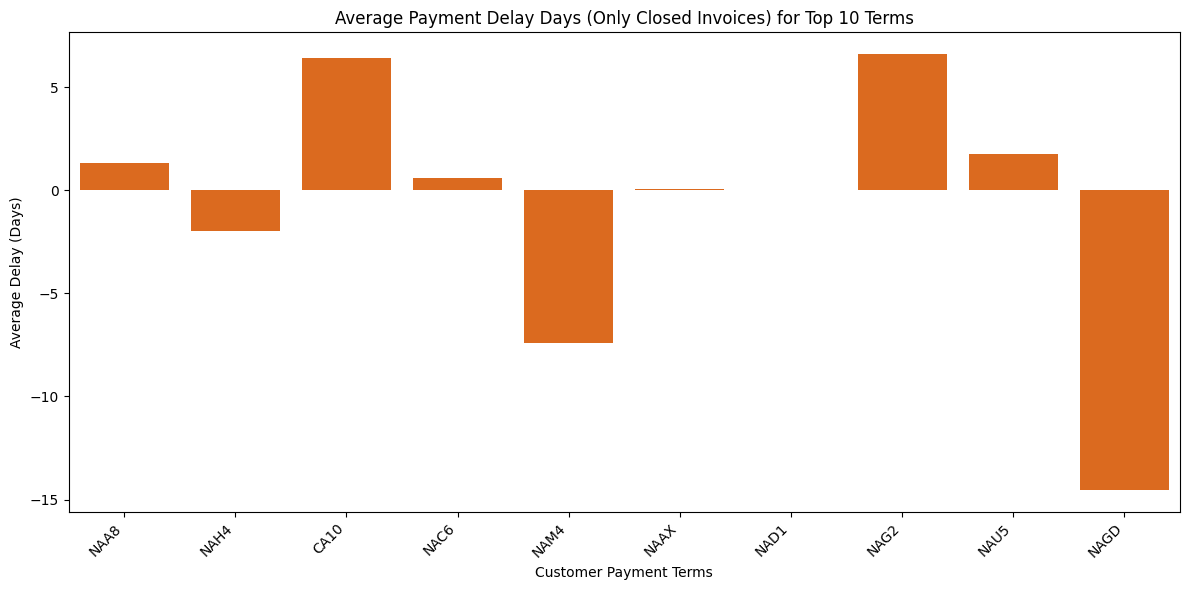


## 3. High-Value vs. Low-Value Segment Analysis

--- High-Value Threshold (75th percentile): $46,543.02 ---

--- Delay Metrics by Invoice Value Segment ---


,value_segment,n_invoices,total_invoices_amount,avg_delay_days,median_delay_days,n_late,total_late_cost,pct_late,pct_total_cost
0,High-Value,10000,8.588181e+08,0.637800,0.0,2949,472456.991633,29.5,60.4
1,Low-Value,29994,4.237833e+08,0.904333,0.0,9021,309702.607510,30.1,39.6


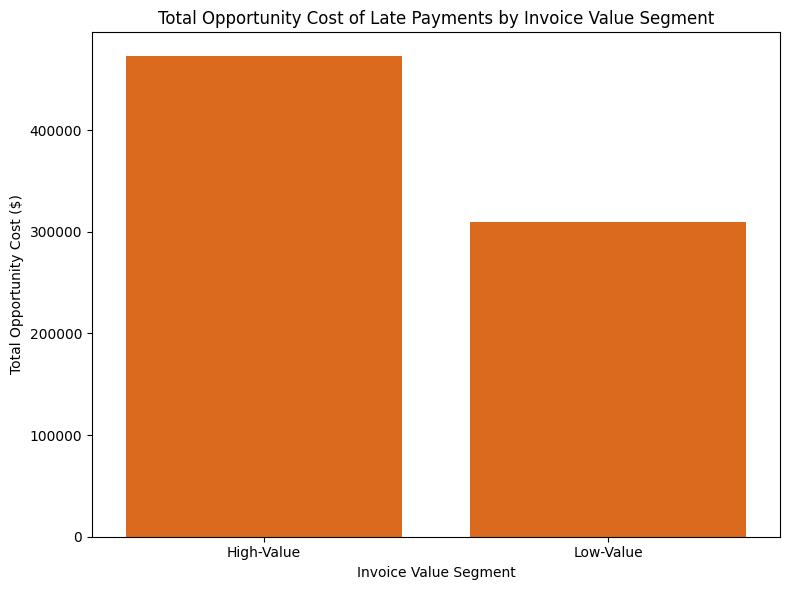


## 1. Predictive Model for Late Payments (Logistic Regression)

--- Predictive Model Performance (Logistic Regression) ---
               precision    recall  f1-score   support

On Time/Early       0.82      0.62      0.71      5607
         Late       0.43      0.68      0.53      2393

     accuracy                           0.64      8000
    macro avg       0.63      0.65      0.62      8000
 weighted avg       0.70      0.64      0.66      8000



KeyError: "['days_to_due', 'effective_posting_delay'] not in index"

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- 0. Define Colors and Parameters ---
tr_orange = "#FA6400"
tr_green = "#123021"
ANNUAL_RATE = 0.10
DAILY_RATE = ANNUAL_RATE / 365
HIGH_VALUE_PERCENTILE = 0.75 # Used for segmentation


# --- 1. Data Loading and Cleaning ---

df = pd.read_csv("dataset.csv", delimiter=";")

# Helper Function for Date Cleaning
def fix_date(col):
    """Converts YYYYMMDD(.0) float/int columns to datetime objects."""
    return (
        col.astype(str)
        .str.replace(".0", "", regex=False)
        .str.zfill(8)
        .pipe(pd.to_datetime, format="%Y%m%d", errors="coerce")
    )

# Clean date columns
raw_yyyymmdd_cols = [
    "document_create_date",
    "document_create_date.1",
    "due_in_date",
    "baseline_create_date"
]
for col in raw_yyyymmdd_cols:
    df[col] = fix_date(df[col])

proper_date_cols = [
    "posting_date",
    "clear_date"
]
for col in proper_date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")
    
# Customer ID and Name Cleaning (using functions from original notebook)
unique_customers_number = df["cust_number"].unique()
unique_customers = sorted(unique_customers_number)
mapping = {
    cust: 100000 + i
    for i, cust in enumerate(unique_customers)
}
df["customer_alt_id"] = df["cust_number"].map(mapping)

df["name_normalized"] = (
    df["name_customer"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

name_counts = (
    df.groupby(["customer_alt_id", "name_normalized"])
    .size()
    .reset_index(name="count")
)

most_frequent_names = (
    name_counts
    .sort_values(["customer_alt_id", "count"], ascending=[True, False])
    .drop_duplicates(subset=["customer_alt_id"])
    .rename(columns={"name_normalized": "customer_clean_name"})
    .loc[:, ["customer_alt_id", "customer_clean_name"]]
)
df = df.merge(most_frequent_names, on="customer_alt_id", how="left")

name_counts_per_clean = most_frequent_names["customer_clean_name"].value_counts()
shared_names = name_counts_per_clean[name_counts_per_clean > 1].index

def make_display_name(row):
    base = row["customer_clean_name"]
    if base in shared_names:
        return f"{base} {row['customer_alt_id']}"
    else:
        return base

most_frequent_names["customer_display_name"] = most_frequent_names.apply(
    make_display_name, axis=1
)
df = df.merge(
    most_frequent_names[["customer_alt_id", "customer_display_name"]],
    on="customer_alt_id",
    how="left"
)

# Separate Closed and Open Invoices
closed_invoices = df[df["isOpen"] == 0].copy()
open_invoices = df[df["isOpen"] == 1].copy()


# --- Calculate Core Delay Metrics for CLOSED INVOICES ---
closed_invoices["delay_days"] = (
    closed_invoices["clear_date"] - closed_invoices["due_in_date"]
).dt.days
closed_invoices["late_days"] = closed_invoices["delay_days"].clip(lower=0)

# Calculate cost of late payments
closed_invoices["late_cost"] = (
    closed_invoices["total_open_amount"] *
    DAILY_RATE *
    closed_invoices["late_days"]
)

# Calculate internal posting delay (for use in prediction)
closed_invoices["earliest_creation_date"] = closed_invoices[
    ["document_create_date", "document_create_date.1"]
].min(axis=1)

closed_invoices["posting_delay_days"] = (
    closed_invoices["posting_date"] - closed_invoices["earliest_creation_date"]
).dt.days

closed_invoices["effective_posting_delay"] = closed_invoices["posting_delay_days"].apply(
    lambda x: max(0, x - 1) # 1 day tolerance
)

# ----------------------------------------------------
# 2. Payment Terms Analysis (Segmentation)
# ----------------------------------------------------
print("## 2. Payment Terms Analysis (Segmentation)")

payment_terms_analysis = (
    closed_invoices
    .groupby("cust_payment_terms")
    .agg(
        n_invoices=("invoice_id", "count"),
        avg_delay_days=("delay_days", "mean"),
        median_delay_days=("delay_days", "median"),
        n_late=("late_days", lambda x: (x > 1).sum()), # Late is > 1 day delay for more stringent definition
        total_late_cost=("late_cost", "sum")
    )
    .reset_index()
    .sort_values("n_invoices", ascending=False)
)

# Calculate percentage of late invoices
payment_terms_analysis["pct_late"] = (
    payment_terms_analysis["n_late"] / payment_terms_analysis["n_invoices"] * 100
).round(1)

# Select and display top 10 most frequent payment terms
top_10_terms = payment_terms_analysis.head(10).copy()
print("\n--- Key Metrics by Payment Terms (Top 10) ---")
display(top_10_terms[[
    "cust_payment_terms",
    "n_invoices",
    "avg_delay_days",
    "median_delay_days",
    "n_late",
    "total_late_cost",
    "pct_late"
]])


# --- Visualization: Average Delay by Payment Terms ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10_terms,
    x="cust_payment_terms",
    y="avg_delay_days",
    color=tr_orange # Use tr_orange for bars
)
plt.title("Average Payment Delay Days (Only Closed Invoices) for Top 10 Terms")
plt.xlabel("Customer Payment Terms")
plt.ylabel("Average Delay (Days)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# ----------------------------------------------------
# 3. High-Value vs. Low-Value Segment Analysis
# ----------------------------------------------------
print("\n" + "="*50)
print("## 3. High-Value vs. Low-Value Segment Analysis")

# Define the High-Value Threshold
high_value_threshold = closed_invoices["total_open_amount"].quantile(HIGH_VALUE_PERCENTILE)

closed_invoices["value_segment"] = closed_invoices["total_open_amount"].apply(
    lambda x: "High-Value" if x >= high_value_threshold else "Low-Value"
)

value_segment_analysis = (
    closed_invoices
    .groupby("value_segment")
    .agg(
        n_invoices=("invoice_id", "count"),
        total_invoices_amount=("total_open_amount", "sum"),
        avg_delay_days=("delay_days", "mean"),
        median_delay_days=("delay_days", "median"),
        n_late=("late_days", lambda x: (x > 1).sum()),
        total_late_cost=("late_cost", "sum")
    )
    .reset_index()
)

# Calculate derived metrics
total_cost_all = value_segment_analysis["total_late_cost"].sum()
value_segment_analysis["pct_late"] = (
    value_segment_analysis["n_late"] / value_segment_analysis["n_invoices"] * 100
).round(1)
value_segment_analysis["pct_total_cost"] = (
    value_segment_analysis["total_late_cost"] / total_cost_all * 100
).round(1)


print(f"\n--- High-Value Threshold (75th percentile): ${high_value_threshold:,.2f} ---")
print("\n--- Delay Metrics by Invoice Value Segment ---")
display(value_segment_analysis[[
    "value_segment",
    "n_invoices",
    "total_invoices_amount",
    "avg_delay_days",
    "median_delay_days",
    "n_late",
    "total_late_cost",
    "pct_late",
    "pct_total_cost"
]])

# --- Visualization: Total Opportunity Cost by Invoice Value Segment ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=value_segment_analysis,
    x="value_segment",
    y="total_late_cost",
    color=tr_orange # Use tr_orange for bars
)
plt.title("Total Opportunity Cost of Late Payments by Invoice Value Segment")
plt.xlabel("Invoice Value Segment")
plt.ylabel("Total Opportunity Cost ($)")
plt.tight_layout()
plt.show()


# ----------------------------------------------------
# 1. Predictive Model for Late Payments
# ----------------------------------------------------
print("\n" + "="*50)
print("## 1. Predictive Model for Late Payments (Logistic Regression)")

# 1. Prepare Target Variable (Late: delay_days > 1)
closed_invoices["target_late"] = closed_invoices["delay_days"].apply(
    lambda x: 1 if x > 1 else 0
)

# 2. Feature Engineering & Selection
features = [
    "total_open_amount",
    "days_to_due",  
    "effective_posting_delay", 
    "cust_payment_terms",
    "business_code",
    "invoice_currency"
]

# Recalculate 'days_to_due' for consistency
closed_invoices["days_to_due"] = (
    closed_invoices["due_in_date"] - closed_invoices["posting_date"]
).dt.days

model_df = closed_invoices[
    closed_invoices['clear_date'].notna()
][features + ["target_late"]].copy()

# 3. Handle Categorical Variables (One-Hot Encoding)
X = model_df.drop(columns=['target_late'])
y = model_df['target_late']
X_encoded = pd.get_dummies(X, columns=['cust_payment_terms', 'business_code', 'invoice_currency'], drop_first=True)

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 5. Train Model
model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced') # Use class_weight for better recall on the minority class
model.fit(X_train, y_train)

# 6. Evaluate Model
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['On Time/Early', 'Late'])

print("\n--- Predictive Model Performance (Logistic Regression) ---")
print(report)

# 7. Apply the model to OPEN INVOICES to predict risk
open_invoices_model = df[df["isOpen"] == 1].copy()

# Ensure the required features are present and handle OHE
features_for_open = open_invoices_model[features].copy()
features_for_open["days_to_due"] = (
    features_for_open["due_in_date"] - features_for_open["posting_date"]
).dt.days

open_invoices_encoded = pd.get_dummies(features_for_open, columns=['cust_payment_terms', 'business_code', 'invoice_currency'], drop_first=True)

# Align columns to match training data
for col in X_encoded.columns:
    if col not in open_invoices_encoded.columns:
        open_invoices_encoded[col] = 0

open_invoices_encoded = open_invoices_encoded[X_encoded.columns]

# Predict probabilities
open_invoices_model["late_risk_probability"] = model.predict_proba(open_invoices_encoded)[:, 1]

print("\n--- Top 5 Open Invoices with Highest Risk of Late Payment ---")
risk_invoices = open_invoices_model.sort_values("late_risk_probability", ascending=False).head(5)
display(risk_invoices[["customer_display_name", "total_open_amount", "due_in_date", "late_risk_probability"]])

# --- Visualization: Top 5 Customers by Predicted Risk ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=risk_invoices,
    x="customer_display_name",
    y="late_risk_probability",
    color=tr_orange # Use tr_orange for bars
)
plt.title("Top 5 Open Invoices by Predicted Late Payment Risk")
plt.xlabel("Customer")
plt.ylabel("Predicted Risk of Being Paid Late")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()